In [2]:
import pystac_client
import planetary_computer as pc

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import shapely
import os

## Select GBIF year data

In [3]:
# this data was saved to memory from GBIF datset on the Planetary Comp
# see notebook selecting_gbif_data

gbifdata = 'c_edulis_observations.csv'
obs_all = pd.read_csv(os.path.join(os.getcwd(),'aux_data',gbifdata))

obs_all = gpd.GeoDataFrame(
    obs_all,
    crs = "EPSG:4326",
    geometry = gpd.points_from_xy(
        x= obs_all.decimallongitude,
        y= obs_all.decimallatitude)
)

In [4]:
# select data for year of interest
YEAR = 2016
obs = obs_all.loc[obs_all['year'] == YEAR]
obs = obs[['year',
           'month',
           'geometry', 
           'decimallatitude', 'decimallongitude', 
           'coordinateuncertaintyinmeters',
           'institutioncode']]
obs.reset_index(drop=True, inplace=True)
print('# observations:', obs.shape[0])

# observations: 28


<AxesSubplot:>

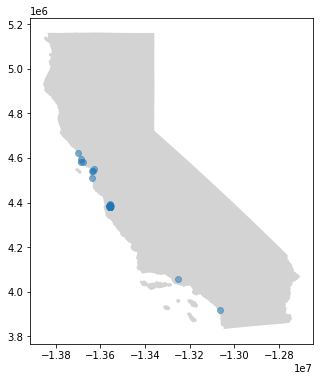

In [5]:
# ---- plot observations over california ----
ca_shape_path = "/home/jovyan/msai4earth-esa/shapefiles_n_rasters/CA_geometry/CA_State_TIGER2016.shp"
ca_shape = gpd.read_file(ca_shape_path)

fig, ax = plt.subplots(figsize = (6,6))
ca_shape.plot(ax=ax, color='lightgrey')
obs[['geometry']].to_crs(ca_shape.crs).plot(ax=ax, alpha=0.5)

## Find NAIP images covering points

In [7]:
# point = shapely point
# year = year of NAIP images
# returns the NAIP image in year covering the point,
#   if there is none it returns None

def query_pt(point, year):

    date_range = str(year)+'-01-01/'+str(year)+'-12-31'

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1")

    search = catalog.search(
        collections=["naip"], 
        intersects=point, 
        datetime=date_range)
    
    items =list(search.get_items()) 
    if len(items)==0:
        return None

    # use the first item (most often for NAIP is only one item having a point per year)
    # ** needs to be updated with whatever info we need to queery in QGIS
    return items[0].id

# ----------------------------------------------------------------------------------
# points = GeoDataFrame
# returns a copy of points with a column including the stac_item_id covering each point

def query(points, year):
    
    date_range = str(year)+'-01-01/'+str(year)+'-12-31'

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1")
    
    stac_item_id = []
    for point in points['geometry']:
        search = catalog.search(
            collections=["naip"], 
            intersects=point, 
            datetime=date_range)

        items =list(search.get_items()) 
        if len(items)==0:
            stac_item_id.append(None)
        else:
        # use the first item (most often for NAIP is only one item having a point per year)
        # ** needs to be updated with whatever info we need to queery in QGIS
            stac_item_id.append(items[0].id)
        
    return points.assign(stac_item_id = stac_item_id)

In [6]:
# ---- TEST query_pt ---
pt = obs['geometry'][0]
for i in range(2010,2020):
    print(i, ':',query_pt(pt,i), '\n')

2010 : None 

2011 : None 

2012 : ca_m_3812260_se_10_1_20120520_20120730 

2013 : None 

2014 : ca_m_3812260_se_10_1_20140608_20140923 

2015 : None 

2016 : ca_m_3812260_se_10_.6_20160531_20161004 

2017 : None 

2018 : ca_m_3812260_se_10_060_20180725_20190209 

2019 : None 



In [8]:
# ----- TEST query -----
obs = query(obs,YEAR)

In [9]:
obs.head(3)

,year,month,geometry,decimallatitude,decimallongitude,coordinateuncertaintyinmeters,institutioncode,stac_item_id
0,2016.0,2.0,POINT (-122.95412 38.12452),38.124518,-122.954118,6.0,iNaturalist,ca_m_3812257_nw_10_.6_20160611_20161004
1,2016.0,11.0,POINT (-123.06357 38.30317),38.303168,-123.063569,145.0,iNaturalist,ca_m_3812348_sw_10_.6_20160610_20161004
2,2016.0,2.0,POINT (-122.96120 38.02759),38.027594,-122.961197,5.0,iNaturalist,ca_m_3812257_sw_10_.6_20160611_20161004


In [11]:
obs.shape

(62, 8)

In [13]:
print(len(set(obs['stac_item_id'])), 'distinct NAIP images cover these points')

29 distinct NAIP images cover these points


## Select imge with most observations and open STAC item

In [10]:
# find the scene with the most points in it
points_by_scene = obs.filter(items=['stac_item_id']).groupby(['stac_item_id']).size().reset_index(name='points_in_scene')
points_by_scene.sort_values(by='points_in_scene', ascending=False, inplace=True)
points_by_scene.reset_index(drop=True,inplace=True)
points_by_scene

,stac_item_id,points_in_scene
0,ca_m_3612126_ne_10_.6_20160527_20161004,14
1,ca_m_3612126_nw_10_.6_20160619_20161004,2
2,ca_m_3311754_sw_11_.6_20160809_20161004,1
3,ca_m_3411956_ne_11_.6_20160719_20161004,1
4,ca_m_3612118_se_10_.6_20160527_20161004,1
5,ca_m_3612127_nw_10_.6_20160527_20161004,1
6,ca_m_3712213_sw_10_.6_20160625_20161004,1
7,ca_m_3712220_ne_10_.6_20160625_20161004,1
8,ca_m_3712221_nw_10_.6_20160625_20161004,1
9,ca_m_3712229_sw_10_.6_20160625_20161004,1


In [11]:
# accesing Azure storage using pystac client
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)
search = catalog.search(
    collections=["naip"],
    ids = [points_by_scene['stac_item_id'][0]]
)
item = list(search.get_items())[0]

In [12]:
def print_dict(dictionary):
    for key, value in dictionary.items():
        print(key, ' : ', value)
    print('\n')
    return

print(item)
print('type:', type(item), '\n')
print_dict(item.properties)
print_dict(item.assets)  # click on rendered preview to see NAIP image on separate window

<Item id=ca_m_3612126_ne_10_.6_20160527_20161004>
type: <class 'pystac.item.Item'> 

gsd  :  0.6
datetime  :  2016-05-27T00:00:00Z
naip:year  :  2016
proj:bbox  :  [606024.0, 4046844.0, 612012.0, 4054152.0]
proj:epsg  :  26910
naip:state  :  ca
proj:shape  :  [12180, 9980]
proj:transform  :  [0.6, 0.0, 606024.0, 0.0, -0.6, 4054152.0, 0.0, 0.0, 1.0]


image  :  <Asset href=https://naipeuwest.blob.core.windows.net/naip/v002/ca/2016/ca_060cm_2016/36121/m_3612126_ne_10_h_20160527.tif>
metadata  :  <Asset href=https://naipeuwest.blob.core.windows.net/naip/v002/ca/2016/ca_fgdc_2016/36121/m_3612126_ne_10_h_20160527.txt>
thumbnail  :  <Asset href=https://naipeuwest.blob.core.windows.net/naip/v002/ca/2016/ca_060cm_2016/36121/m_3612126_ne_10_h_20160527.200.jpg>
tilejson  :  <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=naip&item=ca_m_3612126_ne_10_.6_20160527_20161004&assets=image&asset_bidx=image%7C1%2C2%2C3>
rendered_preview  :  <Asset href=https

In [ ]:
ca_m_3612126_ne_10_.6_20160527_20161004	